Authors:
* Duhr Łukasz, indeks: 136700
* Komkowska Ewa, indeks: 136737

## Loading from file

### Install libraries and read files

In [ ]:
!pip install tspy
!pip install TSPLib95

import tsplib95
import numpy as np
import matplotlib.pyplot as plt
from tspy import TSP
from random import randint
import time

In [ ]:
tsp = TSP()

kroAProblem = tsplib95.load('kroA100.tsp')
kroBProblem = tsplib95.load('kroB100.tsp')

kroAData = kroAProblem.as_name_dict()['node_coords']
kroBData = kroBProblem.as_name_dict()['node_coords']

verticesA = [kroAData[key] for key in kroAData]
verticesB = [kroBData[key] for key in kroBData]

### Convert data to distance matrix

In [ ]:
def distance_matrix(vertices):
  outputMatrix = [[round(np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)) for (x2, y2) in vertices] for (x1, y1) in vertices]

  return np.array(outputMatrix)

In [ ]:
print(distance_matrix(verticesA))
print(distance_matrix(verticesB))

[[   0 1693 2252 ...  783 1468 2643]
 [1693    0 1708 ... 1911 3156 1831]
 [2252 1708    0 ... 1786 3315  454]
 ...
 [ 783 1911 1786 ...    0 1535 2228]
 [1468 3156 3315 ... 1535    0 3760]
 [2643 1831  454 ... 2228 3760    0]]
[[   0 2607  549 ...  229  618 1249]
 [2607    0 3154 ... 2621 3075 2661]
 [ 549 3154    0 ...  571  403 1499]
 ...
 [ 229 2621  571 ...    0  480 1475]
 [ 618 3075  403 ...  480    0 1796]
 [1249 2661 1499 ... 1475 1796    0]]


## Algorithms - exercise 1

### Utility


In [ ]:
def choose_nearest(matrix, invited_vertices, node):
  return np.argmin([matrix[node][i] if i not in invited_vertices and i != node else float('inf') for i in range(0, len(matrix[node]))])

In [ ]:
def calculate_cycle_length(matrix, visited):
  sum = 0
  for graph in visited:
    sum += np.sum([matrix[ graph[idx], graph[idx+1] ] for idx in range(len(graph) - 1)])
  return sum

In [ ]:
def draw_plot(vertices, visited):
  for graph in visited:
    x = [vertices[idx][0] for idx in graph]
    y = [vertices[idx][1] for idx in graph]
    plt.plot(x, y)
  plt.show()

### Greedy algorithm (using nearest neighbor)

In [ ]:
def greedy_nearest_neighbor(distance_matrix, start_node_1):

  # Get indexes of two starting nodes
  node_1 = start_node_1
  node_2 = np.argmax(matrix[node_1])

  visited_1 = [node_1]
  visited_2 = [node_2]

  while len(np.concatenate([visited_1, visited_2])) != len(matrix):
    if len(visited_1) <= len(visited_2):
      vertex = choose_nearest(matrix, np.concatenate([visited_1, visited_2]), node_1)
      visited_1.append(vertex)
      node_1 = vertex
    else:
      vertex = choose_nearest(matrix, np.concatenate([visited_1, visited_2]), node_2)
      visited_2.append(vertex)
      node_2 = vertex

  visited_1.append(visited_1[0])
  visited_2.append(visited_2[0])

  return visited_1, visited_2

  # sum of both cycle
  # print(sum([(matrix[elem][visited_1[i+1]]) for i, elem in enumerate(visited_1[:-1])]) + sum([(matrix[elem][visited_1[i+1]]) for i, elem in enumerate(visited_1[:-1])]))

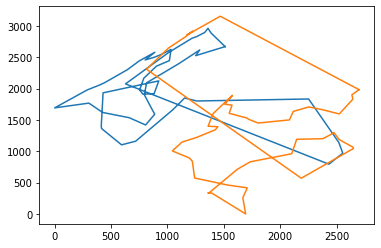

In [ ]:
matrix = distance_matrix(verticesA)
start_node_1 = randint(0, len(matrix)-1)

visited_1, visited_2 = greedy_nearest_neighbor(matrix, start_node_1)
sum = calculate_cycle_length(matrix, [visited_1, visited_2])
draw_plot(matrix, [visited_1, visited_2])

### Greedy algorithm (using greedy cycle)

In [ ]:
def greedy_cycle(matrix, start_node_1):
  # Get indexes of two starting nodes
  node_1 = start_node_1
  node_2 = np.argmax(matrix[node_1])

  # Choose nearest vertices
  min_node_1 = choose_nearest(matrix, [node_1, node_2], node_1)
  min_node_2 = choose_nearest(matrix, [node_1, node_2, min_node_1], node_2)

  visited_1 = [node_1, min_node_1, node_1]
  visited_2 = [node_2, min_node_2, node_2]

  # Find min length in visited vertices until visited all
  while len(np.concatenate([visited_1, visited_2])) != len(matrix):
    min_value = np.inf
    min_index = np.inf
    min_closest_index = np.inf

    visited_list = visited_1 if len(visited_1) <= len(visited_2) else visited_2

    for index in range(len(visited_list) - 1):
      closest = choose_nearest(matrix, np.concatenate([visited_1, visited_2]), visited_list[index])
      for index_2 in range(len(visited_list) - 1):

        fix = matrix[visited_list[index_2], closest] + matrix[visited_list[index_2 + 1], closest] - matrix[visited_list[index_2], visited_list[index_2 + 1]]
        if (fix < min_value):
          min_value = fix
          min_index = index_2 + 1
          min_closest_index = closest

    if len(visited_1) <= len(visited_2):
      visited_1 = np.insert(visited_list, min_index, min_closest_index)
    else:
      visited_2 = np.insert(visited_list, min_index, min_closest_index)

  return visited_1, visited_2

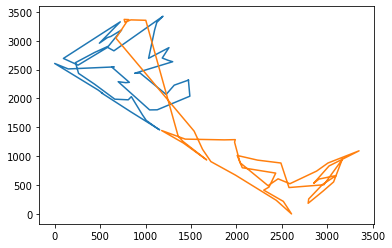

In [ ]:
matrix = distance_matrix(verticesB)
start_node_1 = randint(0, len(matrix)-1)

visited_1, visited_2 = greedy_cycle(matrix, start_node_1)
sum = calculate_cycle_length(matrix, [visited_1, visited_2])
draw_plot(matrix, [visited_1, visited_2])

### Regret heuristic (using 2-regret)

In [ ]:
from heapq import nsmallest

def greedy_regret(matrix, start_node_1):
  # Get indexes of two starting nodes
  node_1 = start_node_1
  node_2 = np.argmax(matrix[node_1])

  # Check as visited
  visited_1 = [node_1]
  visited_2 = [node_2]

  # Choose nearest vertices
  min_node_1 = choose_nearest(matrix, np.concatenate([visited_1, visited_2]), node_1)
  visited_1.append(min_node_1)

  min_node_2 = choose_nearest(matrix, np.concatenate([visited_1, visited_2]), node_2)
  visited_2.append(min_node_2)

  visited_1.append(node_1)
  visited_2.append(node_2)

  # print(visited_1, visited_2)


  while len(np.concatenate([visited_1, visited_2])) != len(matrix):
    max_regret = -float('inf') 
    regret_vertice = None

    visited_list = visited_1 if len(visited_1) <= len(visited_2) else visited_2
    start_regret_first = None
    start_regret_second = None

    for index in range(len(matrix)):
      if index not in np.concatenate([visited_1, visited_2]):
        cost_list = []
        for visited_index, visited_vertex in enumerate(visited_list):
          if visited_index + 1 < len(visited_list):
            cost_list.append(matrix[index][visited_vertex] + matrix[index][visited_list[visited_index + 1]] - matrix[visited_vertex][visited_list[visited_index + 1]])
        
        if start_regret_first is None:
          start_regret_first = np.argmin(cost_list)
          start_regret_second = cost_list.index(nsmallest(2, cost_list)[-1])

        if cost_list[start_regret_first] - cost_list[start_regret_second] > max_regret: 
          regret_vertice = index
          max_regret = cost_list[start_regret_first] - cost_list[start_regret_second]

    min_route = np.inf
    index_from = None
    for index, vertex in enumerate(visited_list):
      if index + 1 < len(visited_list) and matrix[regret_vertice][vertex] + matrix[regret_vertice][visited_list[index + 1]] < min_route:
        min_route = matrix[regret_vertice][vertex] + matrix[regret_vertice][visited_list[index + 1]]
        index_from = index + 1
      
    if len(visited_1) <= len(visited_2):
        visited_1.insert(index_from, regret_vertice)
    else:
        visited_2.insert(index_from, regret_vertice)
    
  return visited_1, visited_2

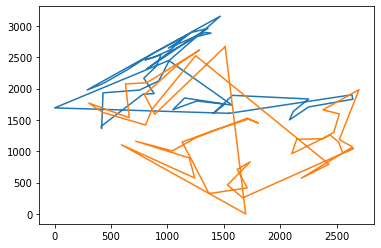

In [ ]:
matrix = distance_matrix(verticesA)
start_node_1 = randint(0, len(matrix)-1)

visited_1, visited_2 = greedy_regret(matrix, start_node_1)
sum = calculate_cycle_length(matrix, [visited_1, visited_2])
draw_plot(matrix, [visited_1, visited_2])

## Algorithms - exercise 2

### Greedy algorithm (changed vertices)

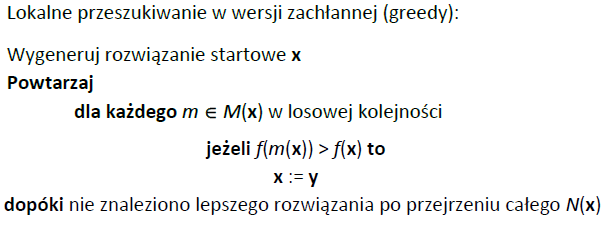

In [ ]:
def look_in_one_list(visited, index, vertice):
  start_solution_sum = calculate_cycle_length(matrix, [visited])
  final_solution_sum = start_solution_sum

  for index_2 in range(1, len(visited) - 1):
    vertice_2 = visited[index_2]
    if abs(index - index_2) >= 1: 
      if abs(index - index_2) == 1:
        if index > index_2:
          delta = matrix[visited[index_2 - 1]][vertice_2] + matrix[visited[index + 1]][vertice] - (matrix[visited[index_2 - 1]][vertice] + matrix[visited[index + 1]][vertice_2])
        else:
          delta = matrix[visited[index_2 + 1]][vertice_2] + matrix[visited[index - 1]][vertice] - (matrix[visited[index_2 + 1]][vertice] + matrix[visited[index - 1]][vertice_2])
      else:
        delta = matrix[visited[index - 1]][vertice] + matrix[visited[index + 1]][vertice] + matrix[visited[index_2 - 1]][vertice_2] + matrix[visited[index_2 + 1]][vertice_2] - (matrix[visited[index - 1]][vertice_2] + matrix[visited[index + 1]][vertice_2] + matrix[visited[index_2 - 1]][vertice] + matrix[visited[index_2 + 1]][vertice])

      if delta > 0:
        final_solution_sum -= delta
        visited[index] = vertice_2
        visited[index_2] = vertice
        vertice = vertice_2

    elif index == 0 and index_2 != index:
      delta = matrix[visited[index - 2]][vertice] + matrix[visited[index + 1]][vertice] + matrix[visited[index_2 - 1]][vertice_2] + matrix[visited[index_2 + 1]][vertice_2] - (matrix[visited[index - 2]][vertice_2] + matrix[visited[index + 1]][vertice_2] + matrix[visited[index_2 - 1]][vertice] + matrix[visited[index_2 + 1]][vertice])

      if delta > 0:
        final_solution_sum -= delta
        visited[index_2] = vertice
        visited[0] = vertice_2
        visited[len(visited) - 1] = vertice_2
        vertice = vertice_2

  return visited


In [ ]:
def greedy_change_vertices(matrix, visited_1, visited_2):
  start_solution_sum = calculate_cycle_length(matrix, [visited_1, visited_2])
  final_solution_sum = start_solution_sum
  changed = []

  final_visited_1 = visited_1
  final_visited_2 = visited_2

  while final_solution_sum >= start_solution_sum and len(changed) < len(final_visited_1) - 3:
      change_index = randint(0, len(final_visited_1) - 2)

      while final_visited_1[change_index] in changed:
        change_index = randint(0, len(final_visited_1) - 2)
      
      start_vertice = final_visited_1[change_index]
      previous_change_index = change_index - 1 if change_index > 0 else len(final_visited_1) - 2
      changed.append(start_vertice) 
      
      final_visited_1 = look_in_one_list(final_visited_1, change_index, start_vertice)

      if change_index < len(final_visited_2):
        final_visited_2 = look_in_one_list(final_visited_2, change_index, final_visited_2[change_index])
      
      final_solution_sum = calculate_cycle_length(matrix, [final_visited_1, final_visited_2])

      for index in range(len(final_visited_2)):
        vertice = final_visited_2[index]
        if index + 1 < len(final_visited_2) and index > 0 and change_index > 0:
          delta = matrix[final_visited_2[index - 1]][vertice] + matrix[final_visited_2[index + 1]][vertice] + \
           matrix[final_visited_1[previous_change_index]][start_vertice] + matrix[final_visited_1[change_index + 1]][start_vertice] - \
           (matrix[final_visited_2[index - 1]][start_vertice] + matrix[final_visited_2[index + 1]][start_vertice] + \
            matrix[final_visited_1[previous_change_index]][vertice] + matrix[final_visited_1[change_index + 1]][vertice])

          if delta > 0:
            final_solution_sum -= delta
            final_visited_1[change_index] = vertice
            final_visited_2[index] = start_vertice
            start_vertice = vertice

        elif index == 0 and change_index > 0:
          delta = matrix[final_visited_2[-2]][vertice] + matrix[final_visited_2[1]][vertice] + \
          matrix[final_visited_1[previous_change_index]][start_vertice] + matrix[final_visited_1[change_index + 1]][start_vertice] - \
          (matrix[final_visited_2[index - 2]][start_vertice] + matrix[final_visited_2[index + 1]][start_vertice] + \
           matrix[final_visited_1[previous_change_index]][vertice] + matrix[final_visited_1[change_index + 1]][vertice])

          if delta > 0:
            final_solution_sum -= delta
            final_visited_1[change_index] = vertice
            final_visited_2[0] = start_vertice
            final_visited_2[len(final_visited_2) - 1] = start_vertice
            start_vertice = vertice

        elif change_index == 0 and index + 1 < len(final_visited_2):
          delta = matrix[final_visited_2[index - 1]][vertice] + matrix[final_visited_2[index + 1]][vertice] + matrix[final_visited_1[change_index - 2]][start_vertice] + matrix[final_visited_1[change_index + 1]][start_vertice] - (matrix[final_visited_2[index - 1]][start_vertice] + matrix[final_visited_2[index + 1]][start_vertice] + matrix[final_visited_1[change_index - 2]][vertice] + matrix[final_visited_1[change_index + 1]][vertice]) 

          if delta > 0:
            final_solution_sum -= delta
            final_visited_2[index] = start_vertice
            final_visited_1[0] = vertice
            final_visited_1[len(final_visited_1) - 1] = vertice  
            start_vertice = vertice

  return final_visited_1, final_visited_2


len of list: 100


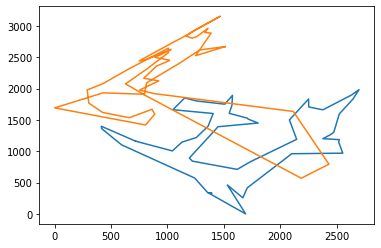

49 49
delta: 181 , len of final_visited_1: 50 , len of final_visited_2: 50


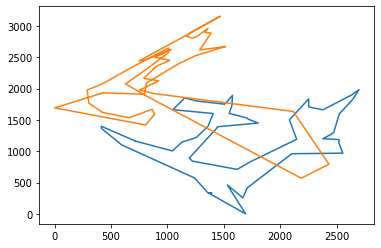

In [ ]:
matrix = distance_matrix(verticesA)
start_node_1 = randint(0, len(matrix)-1)

# TODO: czasem wyrzuca 102 wierzchołki - wejściowo 102 - jakim cudem - w greedy_nearest_neighbor
# visited_1, visited_2 = greedy_nearest_neighbor(matrix, start_node_1)
# visited_1, visited_2 = greedy_regret(matrix, start_node_1)
visited_1, visited_2 = greedy_cycle(matrix, start_node_1)

start_sum = calculate_cycle_length(matrix, [visited_1, visited_2])
print('len of list:', len(np.concatenate([visited_1, visited_2])))
draw_plot(matrix, [visited_1, visited_2])

# dla greedy_cycle:
final_visited_1, final_visited_2 = greedy_change_vertices(matrix, visited_1.tolist(), visited_2.tolist())
# final_visited_1, final_visited_2 = greedy_change_vertices(matrix, visited_1, visited_2)
sum = calculate_cycle_length(matrix, [final_visited_1, final_visited_2])

print(len(set(final_visited_1)), len(set(final_visited_2)))
print('delta:', start_sum - sum, ', len of final_visited_1:', len(final_visited_1),  ', len of final_visited_2:', len(final_visited_2))
draw_plot(matrix, [final_visited_1, final_visited_2])

### Greedy algorithm (changed edges)

In [ ]:
def change_edges_in_one(matrix, visited):
  changed = []
  start_solution_sum = calculate_cycle_length(matrix, [visited])
  final_solution_sum = start_solution_sum

  while final_solution_sum >= start_solution_sum and len(changed) < len(visited) - 2:
    start_index_1 = randint(1, len(visited) - 1)

    while visited[start_index_1] in changed:
      start_index_1 = randint(1, len(visited) - 1)
      
    start_vertice = visited[start_index_1]
    start_index_2 = start_index_1 + 1 if start_index_1 < len(visited) - 1 else 1
    start_vertice_2 = visited[start_index_2]
    changed.append(start_vertice) 

    for index in range(len(visited) - 2):
      change_index_2 = index + 2
      change_index_1 = index + 1
      vertice = visited[change_index_1]
      vertice_2 = visited[change_index_2]

      if change_index_2 != start_index_1 and change_index_2 != start_index_2 and change_index_1 != start_index_2:
        # zamień teraz te krawędzie 
        delta = matrix[start_vertice][start_vertice_2] + matrix[vertice][vertice_2] - (matrix[start_vertice][vertice] + matrix[start_vertice_2][vertice_2])

        if delta > 0:
          if start_index_2 < change_index_1:
            # print('1:', visited)
            visited[start_index_2] = vertice
            visited[start_index_2 + 1:change_index_1] = list(reversed(visited[start_index_2 + 1:change_index_1]))
            visited[change_index_1] = start_vertice_2
            final_solution_sum -= delta
            start_vertice_2 = visited[start_index_2]
            start_vertice = visited[start_index_1]

          else:
            visited[change_index_2] = start_vertice
            visited[change_index_2+1:start_index_1] = list(reversed(visited[change_index_2+1:start_index_1]))
            visited[start_index_1] = vertice_2 
            final_solution_sum -= delta
            start_vertice_2 = visited[start_index_2]
            start_vertice = visited[start_index_1]
            
  return visited

In [ ]:
def greedy_change_edges(matrix, visited_1, visited_2):

  final_visited_1 = change_edges_in_one(matrix, visited_1)
  final_visited_2 = change_edges_in_one(matrix, visited_2)

  return final_visited_1, final_visited_2


len of list: 100


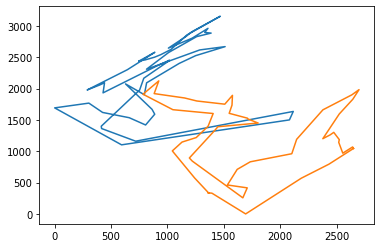

delta: 239


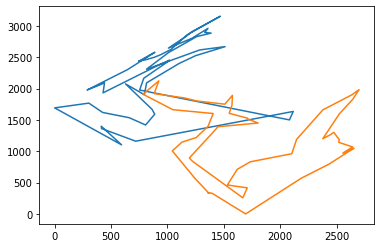

In [ ]:
matrix = distance_matrix(verticesA)
start_node_1 = randint(0, len(matrix)-1)

# visited_1, visited_2 = greedy_nearest_neighbor(matrix, start_node_1)
# visited_1, visited_2 = greedy_regret(matrix, start_node_1)
visited_1, visited_2 = greedy_cycle(matrix, start_node_1)

start_sum = calculate_cycle_length(matrix, [visited_1, visited_2])
print('len of list:', len(np.concatenate([visited_1, visited_2])))
draw_plot(matrix, [visited_1, visited_2])

# dla greedy_cycle:
# final_visited_1, final_visited_2 = greedy_change_edges(matrix, visited_1.tolist(), visited_2.tolist())
final_visited_1, final_visited_2 = greedy_change_edges(matrix, visited_1, visited_2)
sum = calculate_cycle_length(matrix, [final_visited_1, final_visited_2])

print('delta:', start_sum - sum)
# print('len of list:', len(np.concatenate([visited_1, visited_2])), ', len of set final_visited_1:', len(set(final_visited_1)),  ', len of set final_visited_2:', len(set(final_visited_2)))
draw_plot(matrix, [final_visited_1, final_visited_2])

### Steepest algorithm

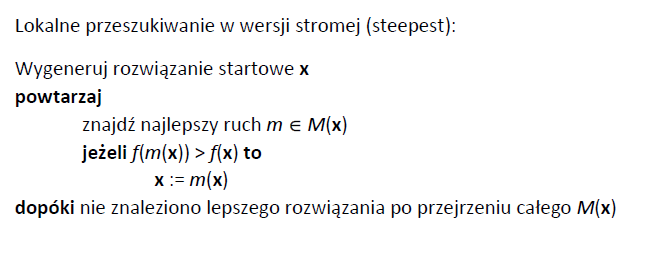

#### Zamiana wierzhołków MIĘDZY grafami


In [ ]:
# zamiana wierzhołków MIĘDZY grafami
def steepest_change_vertices_outer(matrix, visited_1, visited_2):
  best = -np.inf
  vertex_to_change = []
  for first in range(len(visited_1) - 1):
    for second in range(len(visited_2) - 1):
      first_pre,first_next = first-1,first+1
      second_pre,second_next = second-1,second+1
      if (first == 0):
        first_pre = first-2
      if (second == 0):
        second_pre = second-2
      previous = matrix[visited_1[first], visited_1[first_pre]] +\
                 matrix[visited_1[first], visited_1[first_next]] +\
                 matrix[visited_2[second], visited_2[second_pre]] +\
                 matrix[visited_2[second], visited_2[second_next]]
      next = matrix[visited_2[second], visited_1[first_pre]] +\
             matrix[visited_2[second], visited_1[first_next]] +\
             matrix[visited_1[first], visited_2[second_pre]] +\
             matrix[visited_1[first], visited_2[second_next]]

      delta = previous - next
      if (delta > best):
        best = delta
        vertex_to_change = [visited_1[first], visited_2[second]]
  # print('Best delta:',best)
  
  if (best <= 0):
    return
  visited_1[visited_1 == vertex_to_change[0]] = vertex_to_change[1]
  visited_2[visited_2 == vertex_to_change[1]] = vertex_to_change[0]

#### Zamiana wierzchołków WEWNĄTRZ grafu

In [ ]:
# zamiana wierzhołków WEWNĄTRZ grafu
def steepest_change_vertices_inner(matrix, visited):
  best = -np.inf
  vertex_to_change = []
  for first in range(len(visited) - 2):
    for second in range(first + 1, len(visited) - 1):
      first_pre,first_next = first-1,first+1
      second_pre,second_next = second-1,second+1
      if (first == 0):
        first_pre = first-2
      if (first_next == second): # warunek sąsiedztwa
        previous = matrix[visited[first], visited[first_pre]] +\
                  matrix[visited[first], visited[second]] +\
                  matrix[visited[second], visited[first]] +\
                  matrix[visited[second], visited[second_next]]
        next = matrix[visited[second], visited[first_pre]] +\
              matrix[visited[second], visited[first]] +\
              matrix[visited[first], visited[second]] +\
              matrix[visited[first], visited[second_next]]
      else:
        previous = matrix[visited[first], visited[first_pre]] +\
                  matrix[visited[first], visited[first_next]] +\
                  matrix[visited[second], visited[second_pre]] +\
                  matrix[visited[second], visited[second_next]]
        next = matrix[visited[second], visited[first_pre]] +\
              matrix[visited[second], visited[first_next]] +\
              matrix[visited[first], visited[second_pre]] +\
              matrix[visited[first], visited[second_next]]

      delta = previous - next
      if (delta > best):
        best = delta
        vertex_to_change = [visited[first], visited[second]]
  # print(calculate_cycle_length(matrix,[visited]))
  # print('Best delta:',best,'(',calculate_cycle_length(matrix,[visited]),')')
  if (best <= 0):
    return

  visited[visited == vertex_to_change[0]] = vertex_to_change[1]
  visited[visited == vertex_to_change[1]] = vertex_to_change[0]
  # print('Best delta:',best,'(',calculate_cycle_length(matrix,[visited]),')')

#### Zamiana krawędzi WEWNĄTRZ grafu

In [ ]:
# zamiana krawędzi WEWNĄTRZ grafu
def steepest_change_edges_inner(matrix, visited):
  best = -np.inf
  index_to_change = []
  for first in range(len(visited) - 2):
    for second in range(first + 2, len(visited) - 1):
      first_next = first+1
      second_next = second+1
      if (visited[first] == visited[second_next]):
        continue

      previous = matrix[visited[first], visited[first_next]] +\
                matrix[visited[second], visited[second_next]]
      next = matrix[visited[first], visited[second]] +\
            matrix[visited[first_next], visited[second_next]]

      delta = previous - next
      if (delta > best):
        best = delta
        index_to_change = [first_next, second]
  # print('Vertexes to change:',visited[index_to_change[0]],visited[index_to_change[1]])
  # print('Best delta:',best,'(',calculate_cycle_length(matrix,[visited]),')')
  if (best <= 0):
    return
  visited[visited == visited[index_to_change[0]]] = visited[index_to_change[1]]
  visited[visited == visited[index_to_change[1]]] = visited[index_to_change[0]]
  visited[index_to_change[0]+1:index_to_change[1]] = visited[index_to_change[0]+1:index_to_change[1]][::-1]
  # print('Best delta:',best,'(',calculate_cycle_length(matrix,[visited]),')')

#### algorytm v.1
1. inner vertices one
2. inner vertices two
3. outer vertices

In [ ]:
def steepest_change_vertices(matrix, visited_1, visited_2):
  # inner graph 1
  # print('inner vert one')
  while True:
    previous = calculate_cycle_length(matrix,[visited_1])
    steepest_change_vertices_inner(matrix, visited_1)
    next = calculate_cycle_length(matrix,[visited_1])
    # print(previous, '->', next)
    if (next >= previous):
      # print('stop')
      break

  # print('inner vert two')
  # inner graph 2
  while True:
    previous = calculate_cycle_length(matrix,[visited_2])
    steepest_change_vertices_inner(matrix, visited_2)
    next = calculate_cycle_length(matrix,[visited_2])
    # print(previous, '->', next)
    if (next >= previous):
      # print('stop')
      break

  # print('outer vert')
  # outer graphs
  while True:
    previous = calculate_cycle_length(matrix,[visited_1,visited_2])
    steepest_change_vertices_outer(matrix, visited_1, visited_2)
    next = calculate_cycle_length(matrix,[visited_1,visited_2])
    # print(previous, '->', next)
    if (next >= previous):
      # print('stop')
      break

#### algorytm v.2
1. inner edge one
2. inner edge two
3. outer vertices

In [ ]:
def steepest_change_edges(matrix, visited_1, visited_2):
  # inner graph 1
  # print('inner edge one')
  while True:
    previous = calculate_cycle_length(matrix,[visited_1])
    steepest_change_edges_inner(matrix, visited_1)
    next = calculate_cycle_length(matrix,[visited_1])
    # print(previous, '->', next)
    if (next >= previous):
      # print('stop')
      break

  # print('inner edge two')
  # inner graph 2
  while True:
    previous = calculate_cycle_length(matrix,[visited_2])
    steepest_change_edges_inner(matrix, visited_2)
    next = calculate_cycle_length(matrix,[visited_2])
    print(previous, '->', next)
    if (next >= previous):
      print('stop')
      break

  # print('outer vert')
  # outer graphs
  while True:
    previous = calculate_cycle_length(matrix,[visited_1,visited_2])
    steepest_change_vertices_outer(matrix, visited_1, visited_2)
    next = calculate_cycle_length(matrix,[visited_1,visited_2])
    # print(previous, '->', next)
    if (next >= previous):
      # print('stop')
      break

#### Testing


In [ ]:
matrix = distance_matrix(verticesA)
start_node_1 = randint(0, len(matrix)-1)

visited_1, visited_2 = greedy_cycle(matrix, start_node_1)

print('delta_pre:',calculate_cycle_length(matrix,[visited_1,visited_2]))

steepest_change_edges(matrix, visited_1, visited_2)
# steepest_change_vertices(matrix, visited_1, visited_2)

print('delta_post:',calculate_cycle_length(matrix,[visited_1,visited_2]))

# draw_plot(matrix, [final_visited_1, final_visited_2])

delta_pre: 26974
15137 -> 14861
14861 -> 14151
14151 -> 14444
stop
delta_post: 26065


### Random algorithm

In [ ]:
def generate_random(matrix, start_vertex):
  final = [start_vertex]

  while (len(final) < len(matrix) - 1):
    check_index = randint(0, len(matrix) - 1)

    if check_index not in final:
      final.append(check_index)

  return np.array(final[0:49] + [start_vertex]), np.array(final[50:] + [final[50]])

visited_1, visited_2 = generate_random(matrix, 14)

## Tests (x 100)

### Testy dla greedy vertices

Min_value : 25412
Max_value : 29650
Average : 28074.05
Average time: 0.003429622650146484
Min time: 0.0010995864868164062
Max time: 0.01305246353149414
Calculated min:  25412
Before changes: 25428


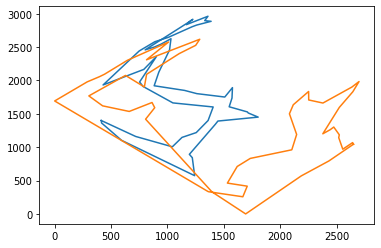

49 49


In [ ]:
values = []
time_values = []
min_value = np.inf
max_value = -np.inf
min_solution = []
final_first_sum = 0

matrix = distance_matrix(verticesA)

for i in range(0, 100):
  visited_1, visited_2 = greedy_cycle(matrix, i)
  first_sum = calculate_cycle_length(matrix, [visited_1, visited_2])
  start = time.time()
  final_visited_1, final_visited_2 = greedy_change_vertices(matrix, visited_1, visited_2)
  end = time.time()
  sum = calculate_cycle_length(matrix, [final_visited_1, final_visited_2])
  if (sum < min_value):
    min_value = sum
    final_first_sum = first_sum
    min_solution = [final_visited_1, final_visited_2]
  if (sum > max_value):
    max_value = sum
  values.append(sum)
  time_values.append(end - start)

print('Min_value :', min_value)
print('Max_value :', max_value)
print('Average :', np.average(values))
print('Average time:', np.average(time_values))
print('Min time:', np.min(time_values))
print('Max time:', np.max(time_values))
print('Calculated min: ', calculate_cycle_length(matrix, min_solution))
print('Before changes:', final_first_sum)
draw_plot(matrix, min_solution)

Min_value : 24337
Max_value : 29650
Average : 26718.27
Average time: 0.003975179195404053
Min time: 0.0010974407196044922
Max time: 0.018602371215820312
Calculated min:  24337
Before changes: 24423


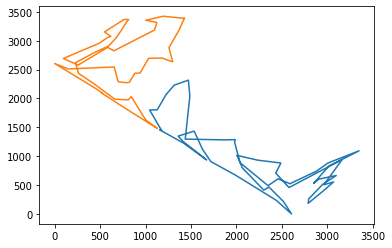

49 49


In [ ]:
values = []
time_values = []
min_value = np.inf
max_value = -np.inf
min_solution = []
final_first_sum = 0

matrix = distance_matrix(verticesB)

for i in range(0, 100):
  visited_1, visited_2 = greedy_cycle(matrix, i)
  first_sum = calculate_cycle_length(matrix, [visited_1, visited_2])
  start = time.time()
  final_visited_1, final_visited_2 = greedy_change_vertices(matrix, visited_1, visited_2)
  end = time.time()
  sum = calculate_cycle_length(matrix, [final_visited_1, final_visited_2])
  if (sum < min_value):
    min_value = sum
    final_first_sum = first_sum
    min_solution = [final_visited_1, final_visited_2]
  if (sum > max_value):
    max_value = sum
  values.append(sum)
  time_values.append(end - start)

print('Min_value :', min_value)
print('Max_value :', max_value)
print('Average :', np.average(values))
print('Average time:', np.average(time_values))
print('Min time:', np.min(time_values))
print('Max time:', np.max(time_values))
print('Calculated min: ', calculate_cycle_length(matrix, min_solution))
print('Before changes:', final_first_sum)
draw_plot(matrix, min_solution)

Min_value : 117927
Max_value : 164051
Average : 135391.52
Average time: 0.0011633372306823731
Min time: 0.0010731220245361328
Max time: 0.0035555362701416016
Calculated min:  117927
Before changes: 144760


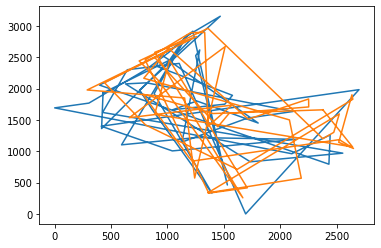

50 50
49 49


In [ ]:
values = []
time_values = []
min_value = np.inf
max_value = -np.inf
min_solution = []
final_first_sum = 0

matrix = distance_matrix(verticesA)

for i in range(0, 100):
  visited_1, visited_2 = generate_random(matrix, i)
  first_sum = calculate_cycle_length(matrix, [visited_1, visited_2])
  start = time.time()
  final_visited_1, final_visited_2 = greedy_change_vertices(matrix, visited_1, visited_2)
  end = time.time()
  sum = calculate_cycle_length(matrix, [final_visited_1, final_visited_2])
  if (sum < min_value):
    min_value = sum
    final_first_sum = first_sum
    min_solution = [final_visited_1, final_visited_2]
  if (sum > max_value):
    max_value = sum
  values.append(sum)
  time_values.append(end - start)

print('Min_value :', min_value)
print('Max_value :', max_value)
print('Average :', np.average(values))
print('Average time:', np.average(time_values))
print('Min time:', np.min(time_values))
print('Max time:', np.max(time_values))
print('Calculated min: ', calculate_cycle_length(matrix, min_solution))
print('Before changes:', final_first_sum)
draw_plot(matrix, min_solution)

Min_value : 113736
Max_value : 158053
Average : 134112.74
Average time: 0.001264774799346924
Min time: 0.0010616779327392578
Max time: 0.0031075477600097656
Calculated min:  113736
Before changes: 155745


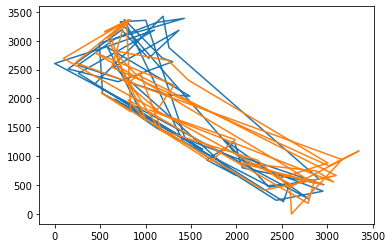

49 49
50 50


In [ ]:
values = []
time_values = []
min_value = np.inf
max_value = -np.inf
min_solution = []
final_first_sum = 0

matrix = distance_matrix(verticesB)

for i in range(0, 100):
  visited_1, visited_2 = generate_random(matrix, i)
  first_sum = calculate_cycle_length(matrix, [visited_1, visited_2])
  start = time.time()
  final_visited_1, final_visited_2 = greedy_change_vertices(matrix, visited_1, visited_2)
  end = time.time()
  sum = calculate_cycle_length(matrix, [final_visited_1, final_visited_2])
  if (sum < min_value):
    min_value = sum
    final_first_sum = first_sum
    min_solution = [final_visited_1, final_visited_2]
  if (sum > max_value):
    max_value = sum
  values.append(sum)
  time_values.append(end - start)

print('Min_value :', min_value)
print('Max_value :', max_value)
print('Average :', np.average(values))
print('Average time:', np.average(time_values))
print('Min time:', np.min(time_values))
print('Max time:', np.max(time_values))
print('Calculated min: ', calculate_cycle_length(matrix, min_solution))
print('Before changes:', final_first_sum)
draw_plot(matrix, min_solution)

### Testy dla greedy edges

Min_value : 25231
Max_value : 29508
Average : 27991.97
Average time: 0.001742691993713379
Min time: 0.0003821849822998047
Max time: 0.006961822509765625
Calculated min:  25231
Before changes: 25479


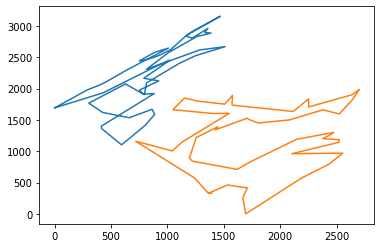

49 49


In [ ]:
values = []
time_values = []
min_value = np.inf
max_value = -np.inf
min_solution = []
final_first_sum = 0

matrix = distance_matrix(verticesA)

for i in range(0, 100):
  visited_1, visited_2 = greedy_cycle(matrix, i)
  first_sum = calculate_cycle_length(matrix, [visited_1, visited_2])
  start = time.time()
  final_visited_1, final_visited_2 = greedy_change_edges(matrix, visited_1, visited_2)
  end = time.time()
  sum = calculate_cycle_length(matrix, [final_visited_1, final_visited_2])
  if (sum < min_value):
    min_value = sum
    final_first_sum = first_sum
    min_solution = [final_visited_1, final_visited_2]
  if (sum > max_value):
    max_value = sum
  values.append(sum)
  time_values.append(end - start)

print('Min_value :', min_value)
print('Max_value :', max_value)
print('Average :', np.average(values))
print('Average time:', np.average(time_values))
print('Min time:', np.min(time_values))
print('Max time:', np.max(time_values))
print('Calculated min: ', calculate_cycle_length(matrix, min_solution))
print('Before changes:', final_first_sum)
draw_plot(matrix, min_solution)

Min_value : 24083
Max_value : 29453
Average : 26593.71
Average time: 0.0015453767776489257
Min time: 0.0003921985626220703
Max time: 0.004047393798828125
Calculated min:  24083
Before changes: 24687


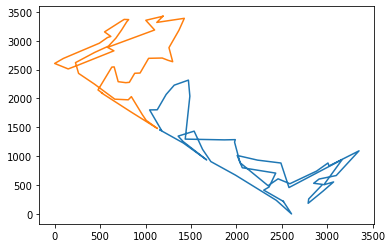

49 49


In [ ]:
values = []
time_values = []
min_value = np.inf
max_value = -np.inf
min_solution = []
final_first_sum = 0

matrix = distance_matrix(verticesB)

for i in range(0, 100):
  visited_1, visited_2 = greedy_cycle(matrix, i)
  first_sum = calculate_cycle_length(matrix, [visited_1, visited_2])
  start = time.time()
  final_visited_1, final_visited_2 = greedy_change_edges(matrix, visited_1, visited_2)
  end = time.time()
  sum = calculate_cycle_length(matrix, [final_visited_1, final_visited_2])
  if (sum < min_value):
    min_value = sum
    final_first_sum = first_sum
    min_solution = [final_visited_1, final_visited_2]
  if (sum > max_value):
    max_value = sum
  values.append(sum)
  time_values.append(end - start)

print('Min_value :', min_value)
print('Max_value :', max_value)
print('Average :', np.average(values))
print('Average time:', np.average(time_values))
print('Min time:', np.min(time_values))
print('Max time:', np.max(time_values))
print('Calculated min: ', calculate_cycle_length(matrix, min_solution))
print('Before changes:', final_first_sum)
draw_plot(matrix, min_solution)

Min_value : 103812
Max_value : 170761
Average : 140802.02
Average time: 0.0004923415184020997
Min time: 0.00035071372985839844
Max time: 0.0006597042083740234
Calculated min:  103812
Before changes: 138707


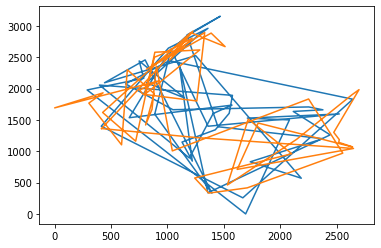

49 49


In [ ]:
values = []
time_values = []
min_value = np.inf
max_value = -np.inf
min_solution = []
final_first_sum = 0

matrix = distance_matrix(verticesA)

for i in range(0, 100):
  visited_1, visited_2 = generate_random(matrix, i)
  first_sum = calculate_cycle_length(matrix, [visited_1, visited_2])
  start = time.time()
  final_visited_1, final_visited_2 = greedy_change_edges(matrix, visited_1, visited_2)
  end = time.time()
  sum = calculate_cycle_length(matrix, [final_visited_1, final_visited_2])
  if (sum < min_value):
    min_value = sum
    final_first_sum = first_sum
    min_solution = [final_visited_1, final_visited_2]
  if (sum > max_value):
    max_value = sum
  values.append(sum)
  time_values.append(end - start)

print('Min_value :', min_value)
print('Max_value :', max_value)
print('Average :', np.average(values))
print('Average time:', np.average(time_values))
print('Min time:', np.min(time_values))
print('Max time:', np.max(time_values))
print('Calculated min: ', calculate_cycle_length(matrix, min_solution))
print('Before changes:', final_first_sum)
draw_plot(matrix, min_solution)

Min_value : 113088
Max_value : 163213
Average : 141715.56
Average time: 0.0005060529708862305
Min time: 0.00039124488830566406
Max time: 0.0007948875427246094
Calculated min:  113088
Before changes: 157346


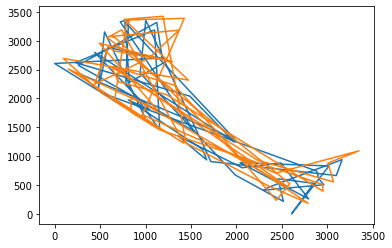

49 49


In [ ]:
values = []
time_values = []
min_value = np.inf
max_value = -np.inf
min_solution = []
final_first_sum = 0

matrix = distance_matrix(verticesB)

for i in range(0, 100):
  visited_1, visited_2 = generate_random(matrix, i)
  first_sum = calculate_cycle_length(matrix, [visited_1, visited_2])
  start = time.time()
  final_visited_1, final_visited_2 = greedy_change_edges(matrix, visited_1, visited_2)
  end = time.time()
  sum = calculate_cycle_length(matrix, [final_visited_1, final_visited_2])
  if (sum < min_value):
    min_value = sum
    final_first_sum = first_sum
    min_solution = [final_visited_1, final_visited_2]
  if (sum > max_value):
    max_value = sum
  values.append(sum)
  time_values.append(end - start)

print('Min_value :', min_value)
print('Max_value :', max_value)
print('Average :', np.average(values))
print('Average time:', np.average(time_values))
print('Min time:', np.min(time_values))
print('Max time:', np.max(time_values))
print('Calculated min: ', calculate_cycle_length(matrix, min_solution))
print('Before changes:', final_first_sum)
draw_plot(matrix, min_solution)

### Testy dla steepest vertices

Min_value : 23167
Max_value : 28071
Average : 25993.16
Average time: 0.09440150737762451
Min time: 0.03535795211791992
Max time: 0.15305709838867188
Calculated min:  23167
Before changes: 25699


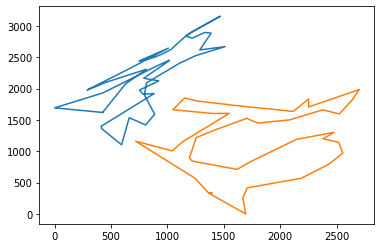

In [ ]:
values = []
time_values = []
min_value = np.inf
max_value = -np.inf
min_solution = []
final_first_sum = 0

matrix = distance_matrix(verticesA)

for i in range(0, 100):
  visited_1, visited_2 = greedy_cycle(matrix, i)
  first_sum = calculate_cycle_length(matrix, [visited_1, visited_2])
  start = time.time()
  steepest_change_vertices(matrix, visited_1, visited_2)
  end = time.time()
  sum = calculate_cycle_length(matrix, [visited_1, visited_2])
  if (sum < min_value):
    min_value = sum
    min_solution = [visited_1, visited_2]
    final_first_sum = first_sum
  if (sum > max_value):
    max_value = sum
  values.append(sum)
  time_values.append(end - start)

print('Min_value :', min_value)
print('Max_value :', max_value)
print('Average :', np.average(values))
print('Average time:', np.average(time_values))
print('Min time:', np.min(time_values))
print('Max time:', np.max(time_values))
print('Calculated min: ', calculate_cycle_length(matrix, min_solution))
print('Before changes:', final_first_sum)
draw_plot(matrix, min_solution)

Min_value : 22116
Max_value : 28252
Average : 25511.09
Average time: 0.07936802387237549
Min time: 0.04010295867919922
Max time: 0.1508026123046875
Calculated min:  22116
Before changes: 25489


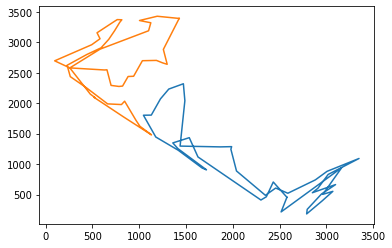

In [ ]:
values = []
time_values = []
min_value = np.inf
max_value = -np.inf
min_solution = []
final_first_sum = 0

matrix = distance_matrix(verticesB)

for i in range(0, 100):
  visited_1, visited_2 = greedy_cycle(matrix, i)
  first_sum = calculate_cycle_length(matrix, [visited_1, visited_2])
  start = time.time()
  steepest_change_vertices(matrix, visited_1, visited_2)
  end = time.time()
  sum = calculate_cycle_length(matrix, [visited_1, visited_2])
  if (sum < min_value):
    min_value = sum
    final_first_sum = first_sum
    min_solution = [visited_1, visited_2]
  if (sum > max_value):
    max_value = sum
  values.append(sum)
  time_values.append(end - start)

print('Min_value :', min_value)
print('Max_value :', max_value)
print('Average :', np.average(values))
print('Average time:', np.average(time_values))
print('Min time:', np.min(time_values))
print('Max time:', np.max(time_values))
print('Calculated min: ', calculate_cycle_length(matrix, min_solution))
print('Before changes:', final_first_sum)
draw_plot(matrix, min_solution)

Min_value : 81117
Max_value : 161323
Average : 135046.22
Average time: 0.13074286699295043
Min time: 0.047002553939819336
Max time: 0.38266587257385254
Calculated min:  81117
Before changes: 166648


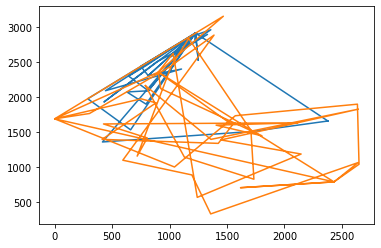

In [ ]:
values = []
time_values = []
min_value = np.inf
max_value = -np.inf
min_solution = []
final_first_sum = 0

matrix = distance_matrix(verticesA)

for i in range(0, 100):
  visited_1, visited_2 = generate_random(matrix, i)
  first_sum = calculate_cycle_length(matrix, [visited_1, visited_2])
  start = time.time()
  steepest_change_vertices(matrix, visited_1, visited_2)
  end = time.time()
  sum = calculate_cycle_length(matrix, [visited_1, visited_2])
  if (sum < min_value):
    min_value = sum
    final_first_sum = first_sum
    min_solution = [visited_1, visited_2]
  if (sum > max_value):
    max_value = sum
  values.append(sum)
  time_values.append(end - start)

print('Min_value :', min_value)
print('Max_value :', max_value)
print('Average :', np.average(values))
print('Average time:', np.average(time_values))
print('Min time:', np.min(time_values))
print('Max time:', np.max(time_values))
print('Calculated min: ', calculate_cycle_length(matrix, min_solution))
print('Before changes:', final_first_sum)
draw_plot(matrix, min_solution)

Min_value : 64494
Max_value : 165943
Average : 132025.93
Average time: 0.13380833148956298
Min time: 0.055043935775756836
Max time: 0.4591250419616699
Calculated min:  64494
Before changes: 167238


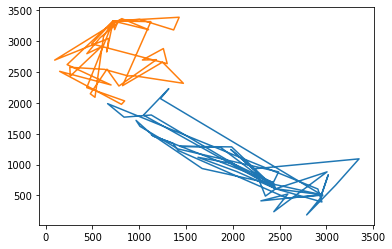

In [ ]:
values = []
time_values = []
min_value = np.inf
max_value = -np.inf
min_solution = []
final_first_sum = 0

matrix = distance_matrix(verticesB)

for i in range(0, 100):
  visited_1, visited_2 = generate_random(matrix, i)
  first_sum = calculate_cycle_length(matrix, [visited_1, visited_2])
  start = time.time()
  steepest_change_vertices(matrix, visited_1, visited_2)
  end = time.time()
  sum = calculate_cycle_length(matrix, [visited_1, visited_2])
  if (sum < min_value):
    min_value = sum
    final_first_sum = first_sum
    min_solution = [visited_1, visited_2]
  if (sum > max_value):
    max_value = sum
  values.append(sum)
  time_values.append(end - start)

print('Min_value :', min_value)
print('Max_value :', max_value)
print('Average :', np.average(values))
print('Average time:', np.average(time_values))
print('Min time:', np.min(time_values))
print('Max time:', np.max(time_values))
print('Calculated min: ', calculate_cycle_length(matrix, min_solution))
print('Before changes:', final_first_sum)
draw_plot(matrix, min_solution)

### Testy dla steepest edges

13072 -> 13488
stop
17310 -> 17034
17034 -> 16324
16324 -> 16617
stop
15317 -> 15985
stop
12649 -> 12434
12434 -> 12310
12310 -> 12226
12226 -> 12154
12154 -> 12043
12043 -> 12009
12009 -> 11873
11873 -> 12394
stop
15770 -> 15253
15253 -> 15094
15094 -> 14962
14962 -> 14578
14578 -> 14529
14529 -> 14428
14428 -> 14625
stop
12649 -> 12434
12434 -> 12310
12310 -> 12226
12226 -> 12154
12154 -> 12043
12043 -> 12009
12009 -> 11873
11873 -> 12394
stop
16698 -> 17366
stop
13072 -> 13488
stop
16698 -> 17366
stop
11816 -> 11692
11692 -> 11608
11608 -> 11528
11528 -> 11322
11322 -> 10962
10962 -> 10836
10836 -> 10836
stop
11837 -> 11713
11713 -> 11629
11629 -> 11549
11549 -> 11343
11343 -> 10983
10983 -> 10857
10857 -> 10857
stop
16698 -> 17366
stop
15137 -> 14861
14861 -> 14151
14151 -> 14444
stop
15317 -> 15985
stop
11837 -> 11713
11713 -> 11629
11629 -> 11549
11549 -> 11343
11343 -> 10983
10983 -> 10857
10857 -> 10857
stop
12649 -> 12434
12434 -> 12310
12310 -> 12226
12226 -> 12154
12154 -> 1

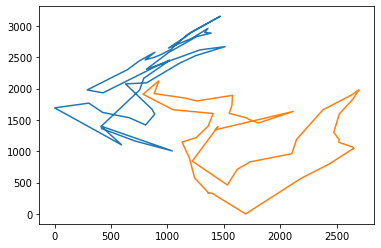

In [ ]:
values = []
time_values = []
min_value = np.inf
max_value = -np.inf
min_solution = []
final_first_sum = 0

matrix = distance_matrix(verticesA)

for i in range(0, 100):
  visited_1, visited_2 = greedy_cycle(matrix, i)
  first_sum = calculate_cycle_length(matrix, [visited_1, visited_2])
  start = time.time()
  steepest_change_edges(matrix, visited_1, visited_2)
  end = time.time()
  sum = calculate_cycle_length(matrix, [visited_1, visited_2])
  if (sum < min_value):
    min_value = sum
    final_first_sum = first_sum
    first_sum = calculate_cycle_length(matrix, [visited_1, visited_2])
    min_solution = [visited_1, visited_2]
  if (sum > max_value):
    max_value = sum
  values.append(sum)
  time_values.append(end - start)

print('Min_value :', min_value)
print('Max_value :', max_value)
print('Average :', np.average(values))
print('Average time:', np.average(time_values))
print('Min time:', np.min(time_values))
print('Max time:', np.max(time_values))
print('Calculated min: ', calculate_cycle_length(matrix, min_solution))
print('Before changes:', first_sum)
draw_plot(matrix, min_solution)

16060 -> 16057
16057 -> 15673
15673 -> 16108
stop
10649 -> 11291
stop
14253 -> 14688
stop
10595 -> 11237
stop
16996 -> 17446
stop
10595 -> 11237
stop
16567 -> 17002
stop
14793 -> 15228
stop
16541 -> 16976
stop
16637 -> 19914
stop
14253 -> 14688
stop
14793 -> 15228
stop
10649 -> 11291
stop
10595 -> 11237
stop
10595 -> 11237
stop
11814 -> 11552
11552 -> 11365
11365 -> 11221
11221 -> 11144
11144 -> 11057
11057 -> 10974
10974 -> 10894
10894 -> 10832
10832 -> 10824
10824 -> 10824
stop
11693 -> 11431
11431 -> 11244
11244 -> 11100
11100 -> 10997
10997 -> 10920
10920 -> 10833
10833 -> 10825
10825 -> 10825
stop
11814 -> 11552
11552 -> 11365
11365 -> 11221
11221 -> 11144
11144 -> 11057
11057 -> 10974
10974 -> 10894
10894 -> 10832
10832 -> 10824
10824 -> 10824
stop
11814 -> 11552
11552 -> 11365
11365 -> 11221
11221 -> 11144
11144 -> 11057
11057 -> 10974
10974 -> 10894
10894 -> 10832
10832 -> 10824
10824 -> 10824
stop
16303 -> 16753
stop
16060 -> 16057
16057 -> 15673
15673 -> 16108
stop
11585 -> 1

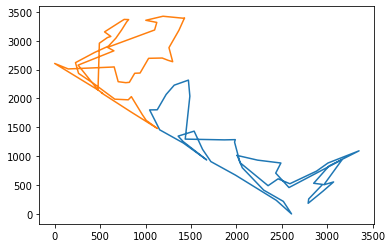

In [ ]:
values = []
time_values = []
min_value = np.inf
max_value = -np.inf
min_solution = []
final_first_sum = 0

matrix = distance_matrix(verticesB)

for i in range(0, 100):
  visited_1, visited_2 = greedy_cycle(matrix, i)
  first_sum = calculate_cycle_length(matrix, [visited_1, visited_2])
  start = time.time()
  steepest_change_edges(matrix, visited_1, visited_2)
  end = time.time()
  sum = calculate_cycle_length(matrix, [visited_1, visited_2])
  if (sum < min_value):
    min_value = sum
    final_first_sum = first_sum
    first_sum = calculate_cycle_length(matrix, [visited_1, visited_2])
    min_solution = [visited_1, visited_2]
  if (sum > max_value):
    max_value = sum
  values.append(sum)
  time_values.append(end - start)

print('Min_value :', min_value)
print('Max_value :', max_value)
print('Average :', np.average(values))
print('Average time:', np.average(time_values))
print('Min time:', np.min(time_values))
print('Max time:', np.max(time_values))
print('Calculated min: ', calculate_cycle_length(matrix, min_solution))
print('Before changes:', first_sum)
draw_plot(matrix, min_solution)

84511 -> 79982
79982 -> 78780
78780 -> 74451
74451 -> 74355
74355 -> 71775
71775 -> 68407
68407 -> 63470
63470 -> 59492
59492 -> 60660
stop
83980 -> 78167
78167 -> 77363
77363 -> 75719
75719 -> 73717
73717 -> 71765
71765 -> 68003
68003 -> 64574
64574 -> 63351
63351 -> 63477
stop
85862 -> 83972
83972 -> 81238
81238 -> 76136
76136 -> 72914
72914 -> 72737
72737 -> 81840
stop
89441 -> 87472
87472 -> 83347
83347 -> 80110
80110 -> 75458
75458 -> 75742
stop
77932 -> 75629
75629 -> 75915
stop
84879 -> 83660
83660 -> 81573
81573 -> 82990
stop
76897 -> 73827
73827 -> 70898
70898 -> 69138
69138 -> 69014
69014 -> 64771
64771 -> 65502
stop
83823 -> 78187
78187 -> 74191
74191 -> 73128
73128 -> 73023
73023 -> 71907
71907 -> 69833
69833 -> 69617
69617 -> 68906
68906 -> 67875
67875 -> 63768
63768 -> 59283
59283 -> 59590
stop
102977 -> 102716
102716 -> 97287
97287 -> 92526
92526 -> 90986
90986 -> 94826
stop
81098 -> 78355
78355 -> 76670
76670 -> 74798
74798 -> 71349
71349 -> 72011
stop
84480 -> 81212
81

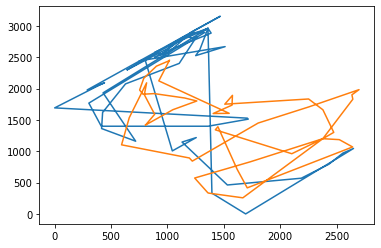

In [ ]:
values = []
time_values = []
min_value = np.inf
max_value = -np.inf
min_solution = []
final_first_sum = 0

matrix = distance_matrix(verticesA)

for i in range(0, 100):
  visited_1, visited_2 = generate_random(matrix, i)
  first_sum = calculate_cycle_length(matrix, [visited_1, visited_2])
  start = time.time()
  steepest_change_edges(matrix, visited_1, visited_2)
  end = time.time()
  sum = calculate_cycle_length(matrix, [visited_1, visited_2])
  if (sum < min_value):
    min_value = sum
    final_first_sum = first_sum
    first_sum = calculate_cycle_length(matrix, [visited_1, visited_2])
    min_solution = [visited_1, visited_2]
  if (sum > max_value):
    max_value = sum
  values.append(sum)
  time_values.append(end - start)

print('Min_value :', min_value)
print('Max_value :', max_value)
print('Average :', np.average(values))
print('Average time:', np.average(time_values))
print('Min time:', np.min(time_values))
print('Max time:', np.max(time_values))
print('Calculated min: ', calculate_cycle_length(matrix, min_solution))
print('Before changes:', first_sum)
draw_plot(matrix, min_solution)

80090 -> 80360
stop
87537 -> 85349
85349 -> 85187
85187 -> 85514
stop
78268 -> 72840
72840 -> 70228
70228 -> 69563
69563 -> 73396
stop
85611 -> 82932
82932 -> 80971
80971 -> 79265
79265 -> 83101
stop
84494 -> 84005
84005 -> 80954
80954 -> 77734
77734 -> 74377
74377 -> 69455
69455 -> 66650
66650 -> 65633
65633 -> 62644
62644 -> 64062
stop
75340 -> 73746
73746 -> 73987
stop
81654 -> 80149
80149 -> 80186
stop
81017 -> 79388
79388 -> 80208
stop
77783 -> 76884
76884 -> 71018
71018 -> 66391
66391 -> 63047
63047 -> 62769
62769 -> 62661
62661 -> 63452
stop
77717 -> 77631
77631 -> 77158
77158 -> 71352
71352 -> 66279
66279 -> 63325
63325 -> 61349
61349 -> 56518
56518 -> 57340
stop
86533 -> 85902
85902 -> 84164
84164 -> 81920
81920 -> 79339
79339 -> 79865
stop
88663 -> 85483
85483 -> 85490
stop
88665 -> 82168
82168 -> 77352
77352 -> 76134
76134 -> 77769
stop
81335 -> 78914
78914 -> 73601
73601 -> 73966
stop
87247 -> 84290
84290 -> 85869
stop
67899 -> 68711
stop
81069 -> 74259
74259 -> 70929
70929

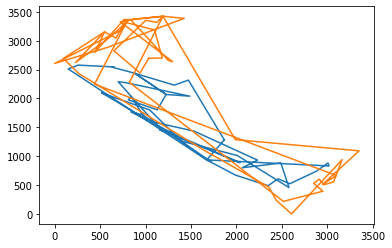

In [ ]:
values = []
time_values = []
min_value = np.inf
max_value = -np.inf
min_solution = []
final_first_sum = 0

matrix = distance_matrix(verticesB)

for i in range(0, 100):
  visited_1, visited_2 = generate_random(matrix, i)
  first_sum = calculate_cycle_length(matrix, [visited_1, visited_2])
  start = time.time()
  steepest_change_edges(matrix, visited_1, visited_2)
  end = time.time()
  sum = calculate_cycle_length(matrix, [visited_1, visited_2])
  if (sum < min_value):
    min_value = sum
    final_first_sum = first_sum
    first_sum = calculate_cycle_length(matrix, [visited_1, visited_2])
    min_solution = [visited_1, visited_2]
  if (sum > max_value):
    max_value = sum
  values.append(sum)
  time_values.append(end - start)

print('Min_value :', min_value)
print('Max_value :', max_value)
print('Average :', np.average(values))
print('Average time:', np.average(time_values))
print('Min time:', np.min(time_values))
print('Max time:', np.max(time_values))
print('Calculated min: ', calculate_cycle_length(matrix, min_solution))
print('Before changes:', first_sum)
draw_plot(matrix, min_solution)